In [6]:
import zipfile, os

zip_path = "gender.zip"   # exact filename from your directory
extract_path = "dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Files extracted to:", extract_path)
print(" Subfolders:", os.listdir(extract_path))


 Files extracted to: dataset
 Subfolders: ['data']


In [7]:
import os

data_path = "dataset/data"
print(" Subfolders in data:", os.listdir(data_path))


 Subfolders in data: ['female', 'male']


In [8]:
import os
import glob

male_path = "dataset/data/male"
female_path = "dataset/data/female"

male_files = glob.glob(os.path.join(male_path, "*.wav"))
female_files = glob.glob(os.path.join(female_path, "*.wav"))

print(" Male samples:", len(male_files))
print(" Female samples:", len(female_files))


 Male samples: 10380
 Female samples: 5768


In [10]:
pip install resampy


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   --- ------------------

Audio loaded! Duration: 4.0 seconds


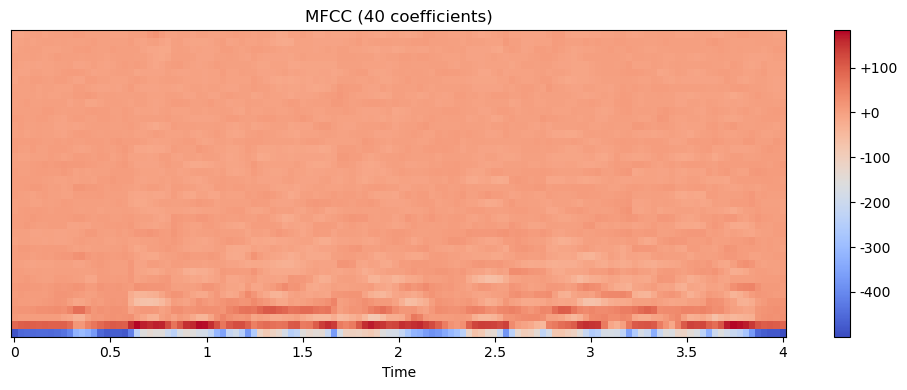

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Test file path (adjust if needed)
file_path = "dataset/data/male/arctic_a0001.wav"

# Load audio
y, sr = librosa.load(file_path, sr=None)  # sr=None keeps original sample rate
print("Audio loaded! Duration:", librosa.get_duration(y=y, sr=sr), "seconds")

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")
plt.title("MFCC (40 coefficients)")
plt.tight_layout()
plt.show()


In [2]:
import os
import numpy as np
import librosa

# Paths to male & female folders
male_path = "dataset/data/male"
female_path = "dataset/data/female"

X = []
y = []

def extract_features(file_path, n_mfcc=40, max_len=174):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extract MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # Pad or truncate to fixed length (for equal input size)
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0,0),(0,pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]
        
        return mfccs
    except Exception as e:
        print("Error extracting from", file_path, ":", e)
        return None

# Process male voices
for file in os.listdir(male_path):
    file_path = os.path.join(male_path, file)
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(0)  # male = 0

# Process female voices
for file in os.listdir(female_path):
    file_path = os.path.join(female_path, file)
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(1)  # female = 1

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(" Features extracted!")
print("X shape:", X.shape)
print("y shape:", y.shape)


 Features extracted!
X shape: (16148, 40, 174)
y shape: (16148,)


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape X for CNN input: (samples, height, width, channels)
X = X[..., np.newaxis]  # add channel dimension → (16148, 40, 174, 1)

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode labels (0 → [1,0], 1 → [0,1])
y_train = to_categorical(y_train, num_classes=2)
y_test  = to_categorical(y_test, num_classes=2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (12918, 40, 174, 1)
y_train shape: (12918, 2)
X_test shape: (3230, 40, 174, 1)
y_test shape: (3230, 2)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40,174,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 classes: male/female
])

model.summary()


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 38, 172, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 17, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 40, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 40, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         983,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,076,994 (4.11 MB)

 Trainable params: 1,076,546 (4.11 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,          # you can adjust (10–30 usually good)
    batch_size=32,      # depends on RAM
    verbose=1
)

Epoch 1/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 104s 238ms/step - accuracy: 0.9805 - loss: 0.1069 - val_accuracy: 0.9947 - val_loss: 0.0169
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 102s 252ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 3.3651e-04
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 138s 243ms/step - accuracy: 0.9968 - loss: 0.0103 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 101s 251ms/step - accuracy: 0.9978 - loss: 0.0083 - val_accuracy: 0.9935 - val_loss: 0.0364
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 96s 238ms/step - accuracy: 0.9985 - loss: 0.0083 - val_accuracy: 0.9985 - val_loss: 0.0042
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 96s 239ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9985 - val_loss: 0.0032
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 95s 236ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9972 - val_loss: 0.0084
Epoch 8/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 99s 245ms/step - accuracy: 0.9976 -

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_acc)


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 1.0000 - loss: 2.6200e-05
Test Accuracy: 1.0


In [11]:
model.save("voice_gender_model.h5")


In [12]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("voice_gender_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp2a0z1j_h\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp2a0z1j_h\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmp2a0z1j_h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 174, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2637103061264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103062032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103061648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103060880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103060688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103061840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103061072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103063184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103062800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103062608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103

In [13]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter.convert()
with open("voice_gender_model_quant.tflite", "wb") as f:
    f.write(quant_tflite_model)


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp_0bbeu7w\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp_0bbeu7w\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmp_0bbeu7w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 174, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2637103061264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103062032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103061648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103060880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103060688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103061840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103061072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103063184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103062800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103062608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2637103

In [19]:
n_mfcc = 20       # reduce from 40 → 20
n_fft = 512       # smaller FFT window
hop_length = 256  # step size between frames


In [22]:
def extract_features(file_path, max_pad_len=100):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20, 
                                     n_fft=512, hop_length=256)
        # Pad or truncate to fixed length (100 frames)
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        return None 
    return mfccs
    # Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Show shapes
print(" Features extracted successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)



 Features extracted successfully!
X shape: (16148, 40, 174, 1)
y shape: (16148,)


In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape X for CNN input: (samples, height, width, channels)
X = X[..., np.newaxis]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=2)
y_test  = to_categorical(y_test, num_classes=2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (12918, 40, 174, 1, 1)
y_train shape: (12918, 2)
X_test shape: (3230, 40, 174, 1, 1)
y_test shape: (3230, 2)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(8, (3,3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 38, 172, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 19, 86, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 17, 84, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 42, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │         172,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,378 (677.26 KB)

 Trainable params: 173,378 (677.26 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,        # keep small at first
    batch_size=32,
    verbose=1
)


Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9432 - loss: 0.1782 - val_accuracy: 0.9957 - val_loss: 0.0209
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9890 - loss: 0.0267 - val_accuracy: 0.9978 - val_loss: 0.0069
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9922 - loss: 0.0200 - val_accuracy: 0.9997 - val_loss: 0.0044
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9923 - loss: 0.0153 - val_accuracy: 0.9991 - val_loss: 0.0014
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9953 - loss: 0.0113 - val_accuracy: 0.9997 - val_loss: 8.4216e-04
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9918 - loss: 0.0173 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9937 - loss: 0.0139 - val_accuracy: 0.9991 - val_loss: 0.0023
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9950 - loss: 0.0183 - val

In [26]:
model.save("voice_gender_small.h5")
print(" Saved: voice_gender_small.h5")


 Saved: voice_gender_small.h5


In [27]:
import os

model_path = os.path.abspath("voice_gender_small.h5")
print(" Model saved at:", model_path)


 Model saved at: C:\Users\User\voice_gender_small.h5


In [2]:
import zipfile, os

zip_path = "gender.zip"   # exact filename from your directory
extract_path = "dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Files extracted to:", extract_path)
print(" Subfolders:", os.listdir(extract_path))

 Files extracted to: dataset
 Subfolders: ['data']


In [3]:
import os

data_path = "dataset/data"
print(" Subfolders in data:", os.listdir(data_path))


 Subfolders in data: ['female', 'male']


In [4]:
import os
import glob

male_path = "dataset/data/male"
female_path = "dataset/data/female"

male_files = glob.glob(os.path.join(male_path, "*.wav"))
female_files = glob.glob(os.path.join(female_path, "*.wav"))

print(" Male samples:", len(male_files))
print(" Female samples:", len(female_files))

 Male samples: 10380
 Female samples: 5768


In [6]:
import os
import librosa
import numpy as np
import pandas as pd

DATASET_PATH = "dataset/data"   # adjust to your dataset root
labels = {"male": 0, "female": 1}

features = []
targets = []

# Limit samples
max_samples_per_class = 60   # keep it small for now

for label in labels:
    folder = os.path.join(DATASET_PATH, label)
    files = [f for f in os.listdir(folder) if f.endswith(".wav")]
    
    # Take only first N files
    files = files[:max_samples_per_class]
    
    for file in files:
        path = os.path.join(folder, file)
        try:
            y, sr = librosa.load(path, sr=16000)  # resample to 16kHz
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)  # 20 MFCCs
            mfcc_mean = np.mean(mfcc.T, axis=0)  # average over time
            features.append(mfcc_mean)
            targets.append(labels[label])
        except Exception as e:
            print("Error with file:", path, "->", e)

df = pd.DataFrame(features)
df["label"] = targets
df.to_csv("voice_features_small.csv", index=False)

print("CSV saved: voice_features_small.csv, shape:", df.shape)


CSV saved: voice_features_small.csv, shape: (120, 21)


In [8]:
import os
import numpy as np
import librosa
import pandas as pd

# Paths to male & female folders
male_path = "dataset/data/male"
female_path = "dataset/data/female"

X = []
y = []

# Limit number of samples per class
max_samples_per_class = 60

def extract_features(file_path, n_mfcc=40):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=16000)  # force resample to 16kHz

        # Extract MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

        # Take mean across time axis -> (40,) feature vector
        mfccs_mean = np.mean(mfccs.T, axis=0)

        return mfccs_mean
    except Exception as e:
        print("Error extracting from", file_path, ":", e)
        return None

# Process male voices
male_files = [f for f in os.listdir(male_path) if f.endswith(".wav")][:max_samples_per_class]
for file in male_files:
    file_path = os.path.join(male_path, file)
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(0)  # male = 0

# Process female voices
female_files = [f for f in os.listdir(female_path) if f.endswith(".wav")][:max_samples_per_class]
for file in female_files:
    file_path = os.path.join(female_path, file)
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(1)  # female = 1

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(" Features extracted!")
print("X shape:", X.shape)  # (120, 40) expected
print("y shape:", y.shape)

# Save to CSV
df = pd.DataFrame(X)
df["label"] = y
df.to_csv("voice_features_small.csv", index=False)
print("CSV saved: voice_features_small.csv")


 Features extracted!
X shape: (120, 40)
y shape: (120,)
CSV saved: voice_features_small.csv


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("voice_features_small.csv")
X = df.drop("label", axis=1).values
y = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical (0 = male, 1 = female)
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Build a small NN model
model = Sequential([
    Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=30,
    batch_size=8,
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f" Test Accuracy: {acc*100:.2f}%")

# Save model for Cube.AI
model.save("male_female_small.h5")
print("Model saved: male_female_small.h5")


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5104 - loss: 0.7537 - val_accuracy: 0.7500 - val_loss: 0.5549
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6771 - loss: 0.5430 - val_accuracy: 0.9167 - val_loss: 0.3912
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8750 - loss: 0.3775 - val_accuracy: 0.9583 - val_loss: 0.2905
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9479 - loss: 0.2765 - val_accuracy: 0.9583 - val_loss: 0.2213
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9271 - loss: 0.2345 - val_accuracy: 0.9583 - val_loss: 0.1705
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9688 - loss: 0.1810 - val_accuracy: 0.9583 - val_loss: 0.1336
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9375 - loss: 0.1801 - val_accuracy: 0.9583 - val_loss: 0.1117
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9792 - loss: 0.1325 - val_accuracy: 0.9583 - v

 Test Accuracy: 100.00%
Model saved: male_female_small.h5


In [10]:
# After training your model
from tensorflow.keras.models import load_model

# Save as HDF5 (.h5) for Cube.AI
model.save("male_female_small.h5")

print("Model saved at: male_female_small.h5")


Model saved at: male_female_small.h5


In [11]:
import os

model_path = os.path.abspath("male_female_small.h5")
print("Full model path:", model_path)


Full model path: C:\Users\User\male_female_small.h5
